# Import Libraries ⬇

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Loading the dataset 📊

In [ ]:
!file -i ./content/newsfeed.csv

./content/newsfeed.csv: text/csv; charset=utf-8


In [5]:
df = pd.read_csv('newsfeed.csv', encoding='utf-8')
df.sample(10)

,Body,category
2266,العالم باكستان مقتل زوج محسود غار امريكيه لقيت...,2
3584,اقتصاد اعمال الاقتصاد بريطان بدا نمو عد مجموعه...,3
1263,الشرق اوسط مخاوف غز نتشار اء انفلونز خنازير عد...,1
3770,اقتصاد اعمال باباندريو يون تعثر سداد ديو خارجي...,3
1866,الشرق اوسط استراليا جواز استخدم غتيال مبحوح مز...,1
3389,العالم الاندبندنت انتخاب عراق حال كتس حقيقيه ا...,2
3437,العالم الشرط المان عتقل بناني مشتب سرق مسابق ب...,2
570,الشرق اوسط برلمانيون ارقه مقراح ضح ظلم دولي بر...,1
2430,العالم تحقيق دول دي اسراءيل فلسطيني ارتكاب جرا...,2
3980,علوم وتكنولوجيا كنوز عالم معرف مكتب رقميه المك...,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Body      4250 non-null   object
 1   category  4250 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 66.5+ KB


<Axes: ylabel='count'>

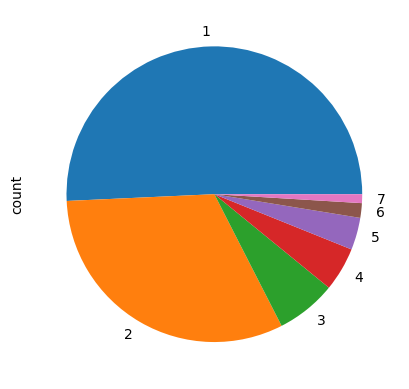

In [7]:
df['category'].value_counts().plot(kind='pie')

# Generate the Embeddings 🚩

In [8]:
corpus = []
for i in range(0, len(df)):
    review = df['Body'][i]
    corpus.append(review)

In [9]:
len(corpus)

4250

In [10]:
### Vocabulary size
voc_size=1000

In [11]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [12]:
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=None) # this will ensure that all the senetences have the same list shape
print(embedded_docs)

[[  0   0   0 ... 202 857 512]
 [  0   0   0 ... 898 936 825]
 [  0   0   0 ... 853 660 436]
 ...
 [  0   0   0 ... 344 737 414]
 [  0   0   0 ...  63 113 379]
 [  0   0   0 ... 727 812 584]]


In [13]:
sequence_lengths = [len(seq) for seq in onehot_repr]

# Find the maximum sequence length
maxlen = np.max(sequence_lengths)
print("Maximum sequence length:", maxlen) # we will use this as an input_length of our Embedding Layer

Maximum sequence length: 3090


# Modeling (Training & Testing) 🏃

## LSTM

In [ ]:
embedding_vector_features = 1000
input_length = maxlen  # Sequence length
num_classes = 8  # the number of classes you have

# Creating the model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=input_length))
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# Compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3090, 1000)        1000000   
                                                                 
 lstm_6 (LSTM)               (None, 3090, 128)         578048    
                                                                 
 dropout_6 (Dropout)         (None, 3090, 128)         0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1710664 (6.53 MB)
Trainable params: 1710

In [ ]:
print(f"the shape of the embedded docs is :  {len(embedded_docs)}")

the shape of the embedded docs is :  4250


In [ ]:
df['category'].shape

(4250,)

In [ ]:
import numpy as np
X=np.array(embedded_docs)
y=np.array(df['category'])

In [ ]:
X

NameError: name 'X' is not defined

In [ ]:
y

array([1, 1, 1, ..., 6, 6, 6])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 80% training, 20% testing

In [ ]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (3400, 3090)
Shape of y_train: (3400,)
Shape of X_test: (850, 3090)
Shape of y_test: (850,)


In [ ]:
max_value = y_train.max()
max_value

7

In [ ]:
y_train = to_categorical(y_train, max_value+1)
y_test = to_categorical(y_test, max_value+1)

In [ ]:
epochs=25
batch_size=64
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test,y_test),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/25
54/54 [==============================] - 28s 427ms/step - loss: 1.3207 - accuracy: 0.5132 - val_loss: 1.0831 - val_accuracy: 0.5894
Epoch 2/25
54/54 [==============================] - 22s 417ms/step - loss: 0.9191 - accuracy: 0.6965 - val_loss: 0.8908 - val_accuracy: 0.7094
Epoch 3/25
54/54 [==============================] - 23s 422ms/step - loss: 0.7786 - accuracy: 0.7694 - val_loss: 1.0692 - val_accuracy: 0.6741
Epoch 4/25
54/54 [==============================] - 23s 429ms/step - loss: 0.7403 - accuracy: 0.7712 - val_loss: 0.9298 - val_accuracy: 0.7282
Epoch 5/25
54/54 [==============================] - 23s 436ms/step - loss: 0.6614 - accuracy: 0.7924 - val_loss: 1.0332 - val_accuracy: 0.6471
Epoch 6/25
54/54 [==============================] - 23s 435ms/step - loss: 0.6329 - accuracy: 0.7835 - val_loss: 0.8529 - val_accuracy: 0.7471
Epoch 7/25
54/54 [==============================] - 24s 442ms/step - loss: 0.8229 - accuracy: 0.6903 - val_loss: 0.9267 - val_accuracy: 0.6835

# Evaluation of the Model 🩺

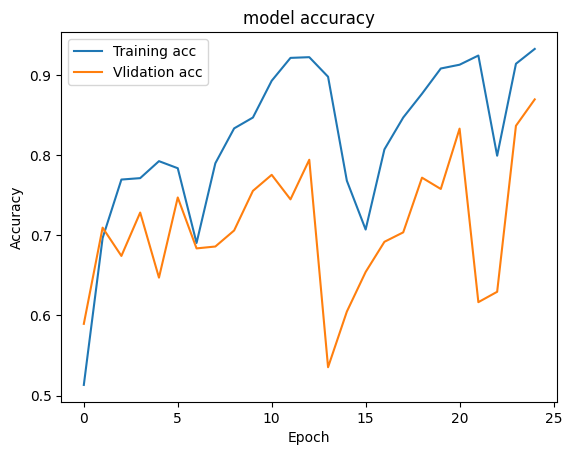

In [ ]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'],label='Vlidation acc')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

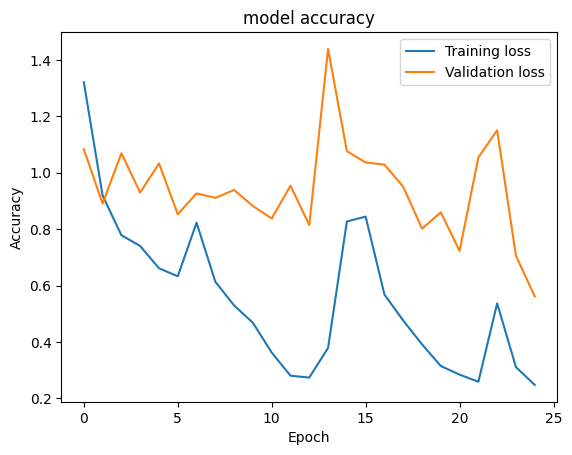

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test data
predictions_prob = model.predict(X_test)
predictions = np.argmax(predictions_prob, axis=1)

27/27 [==============================] - 4s 108ms/step


In [ ]:
true_labels = np.argmax(y_test, axis=1)

In [ ]:
# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       429
           2       0.79      0.93      0.85       260
           3       0.78      0.60      0.68        58
           4       0.52      0.25      0.34        52
           5       0.96      0.73      0.83        33
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         5

    accuracy                           0.87       850
   macro avg       0.58      0.50      0.53       850
weighted avg       0.86      0.87      0.86       850



In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

In [ ]:
class_names = ['Middle East News', 'World News', 'Business and Economy', 'Sports', 'Press Review', 'Science and Technology', 'Miscellaneous']

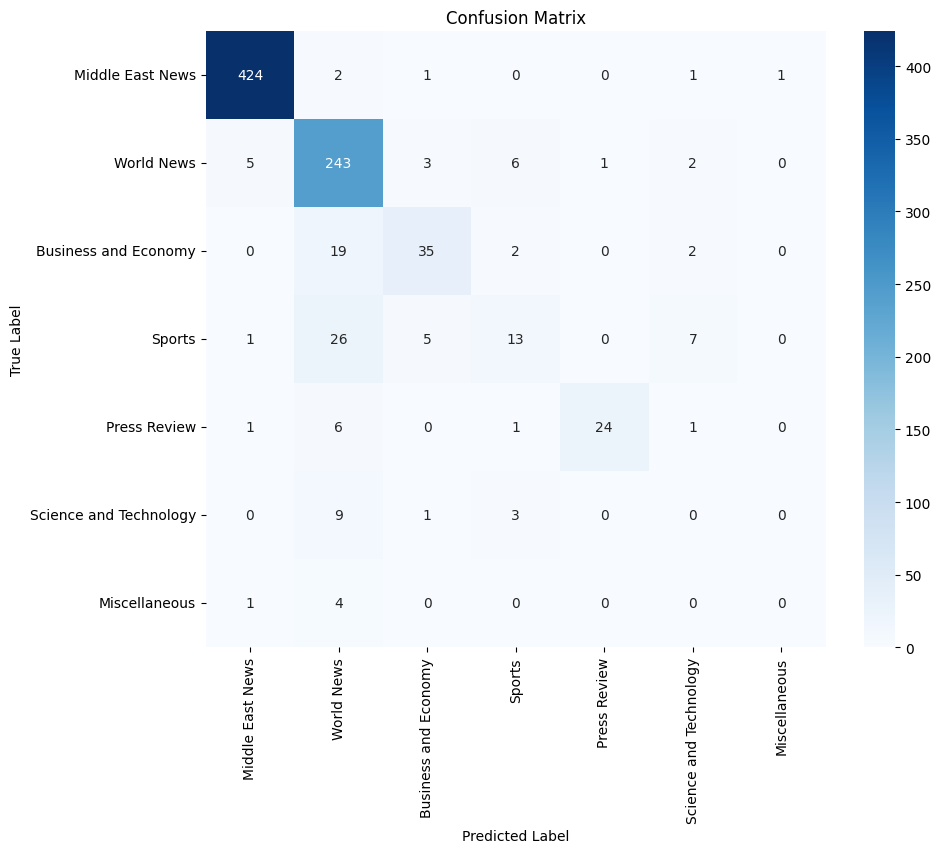

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# CNN

In [14]:
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D

embedding_dim = 1000
input_length = maxlen
num_classes = 8

cnnModel = Sequential()
cnnModel.add(Embedding(voc_size, embedding_dim, input_length = input_length))
cnnModel.add(Conv1D(128, 5, activation = 'relu'))
cnnModel.add(GlobalMaxPooling1D())
cnnModel.add(Dense(16, activation = 'relu'))
cnnModel.add(Dropout(0.7))
cnnModel.add(Dense(num_classes, activation = 'softmax'))

In [15]:
cnnModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3090, 1000)        1000000   
                                                                 
 conv1d (Conv1D)             (None, 3086, 128)         640128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                        

In [17]:
import numpy as np
X = np.array(embedded_docs)
y = np.array(df['category'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (3400, 3090)
Shape of y_train: (3400,)
Shape of X_test: (850, 3090)
Shape of y_test: (850,)


In [20]:
max_value = y_train.max()

In [21]:
y_train = to_categorical(y_train, max_value+1)
y_test = to_categorical(y_test, max_value+1)

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [26]:
# Save best points when the model is improving
cnnModel_best_points_path = './savedArtifacts/cnnModel_Best_points.h5'
MCP = ModelCheckpoint(cnnModel_best_points_path, verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')

# Early stop when the model stops improving
ES = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')

# Reduce the learning rate when the model stops improving, val_loss specifically
RLP = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [27]:
cnnHistory = cnnModel.fit(X_train, y_train,
                    epochs = 25,
                    validation_data = (X_test, y_test),
                    batch_size = 64,
                    callbacks = [MCP, ES, RLP])

Epoch 1/25
54/54 [==============================] - ETA: 0s - loss: 1.6268 - accuracy: 0.3665
Epoch 1: val_accuracy improved from -inf to 0.80824, saving model to ./savedArtifacts/cnnModel_Best_points.h5
54/54 [==============================] - 27s 330ms/step - loss: 1.6268 - accuracy: 0.3665 - val_loss: 0.7911 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.6256
Epoch 2: val_accuracy improved from 0.80824 to 0.90471, saving model to ./savedArtifacts/cnnModel_Best_points.h5
54/54 [==============================] - 12s 220ms/step - loss: 0.9779 - accuracy: 0.6256 - val_loss: 0.3168 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 3/25
54/54 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.7000
Epoch 3: val_accuracy improved from 0.90471 to 0.93765, saving model to ./savedArtifacts/cnnModel_Best_points.h5
54/54 [==============================] - 12s 219ms/step - loss: 0.7268 - accuracy: 0.7000 - val_loss: 0.2600 - val_accuracy: 0.9376 - lr: 0.0010
Epoch 4/25
54/54 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.7309
Epoch 4: val_accuracy did not improve from 0.93765
54/54 [==============================] - 12s 218ms/step - loss: 0.6198 - accuracy: 0.7309 - val_loss: 0.2500 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 5/25
54/54 

In [28]:
score = cnnModel.evaluate(X_test, y_test, verbose = 2)
print("Test score:", score[0])
print('Test accuracy:', score[1])

27/27 - 2s - loss: 0.2600 - accuracy: 0.9376 - 2s/epoch - 60ms/step
Test score: 0.2600342631340027
Test accuracy: 0.9376470446586609


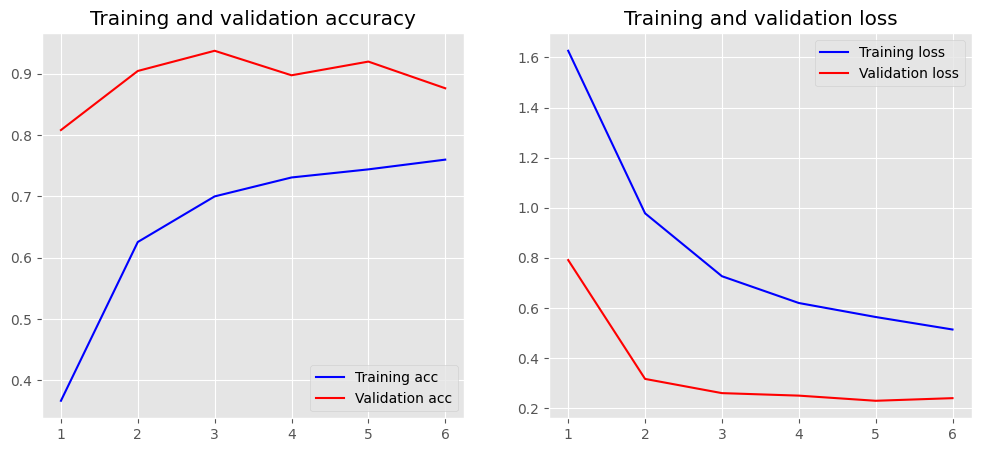

In [29]:
plot_history(cnnHistory)

Text(0, 0.5, 'Accuracy')

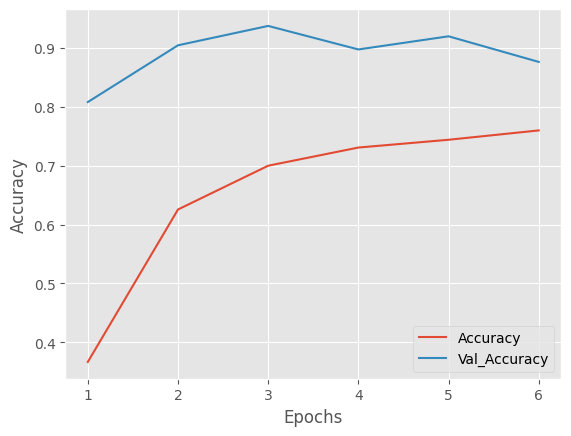

In [30]:
import seaborn as sns
length = len(cnnHistory.history['accuracy'])

plt.figsize = (10,10)
sns.lineplot(x = range(1, 1 + length), y = cnnHistory.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1 + length), y = cnnHistory.history['val_accuracy'], label = 'Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [38]:
cnnPredictions = cnnModel.predict(X_test)
predictions = np.argmax(cnnPredictions, axis=1)

27/27 [==============================] - 1s 32ms/step


In [39]:
true_labels = np.argmax(y_test, axis=1)

In [40]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.93      1.00      0.96       429
           2       0.96      0.99      0.97       260
           3       0.90      0.98      0.94        58
           4       0.98      0.98      0.98        52
           5       0.00      0.00      0.00        33
           6       1.00      0.23      0.38        13
           7       0.00      0.00      0.00         5

    accuracy                           0.94       850
   macro avg       0.68      0.60      0.60       850
weighted avg       0.90      0.94      0.91       850



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


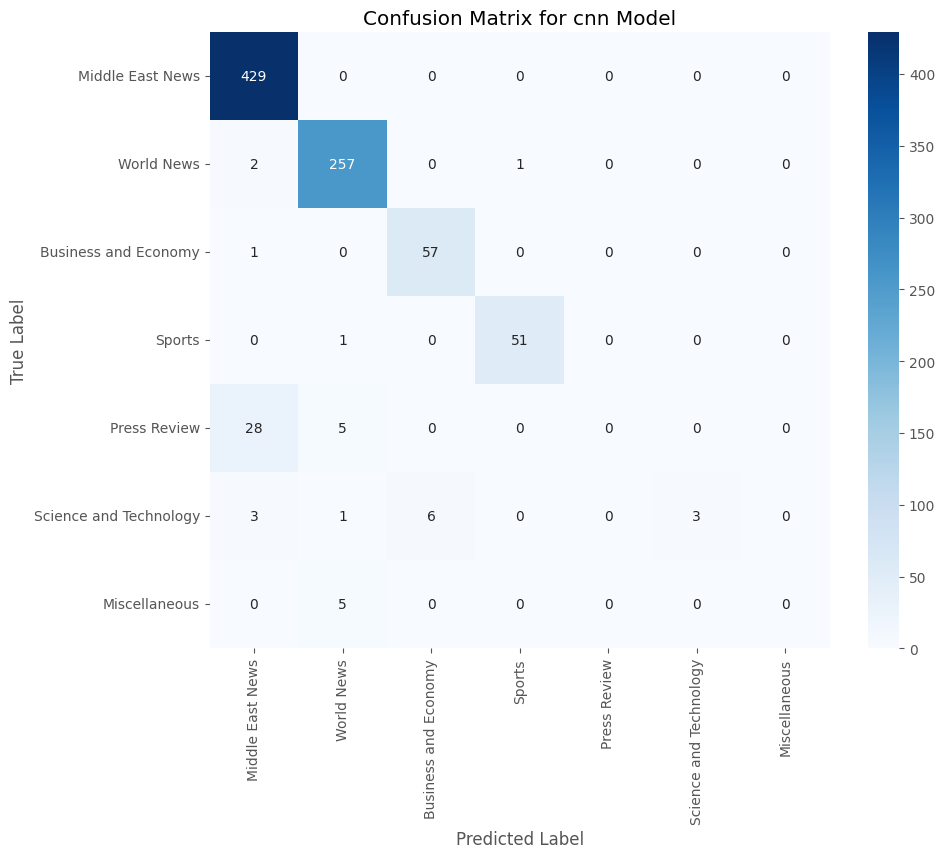

In [41]:
# confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
class_names = ['Middle East News', 'World News', 'Business and Economy', 'Sports', 'Press Review', 'Science and Technology', 'Miscellaneous']
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for cnn Model')

# Show the plot
plt.show()